In [1]:
import random
#On importe pandas et matplotlib pour pouvoir afficher les résultats de manière visuelle, pas strictement nécessaire.
import pandas as pd
import matplotlib.pyplot as plt

# Définir un germe aléatoire pour permettre la reproductibilité des résultats
random_seed = 1234
random.seed(random_seed)
best_fitness_scores = []

In [2]:
#-----------------------------
# GÉNÉRER LE JEU DE DONNÉES
#-----------------------------

# Définition des constantes pour le jeu de données
PROFESSORS = 10
COURSES = 50
ROOMS = 4
TIME_SLOTS = 4
DAYS = 5

if ROOMS <= COURSES / (TIME_SLOTS * DAYS):
    raise ValueError("Il n'y a pas assez de salles pour accueillir tous les cours compte tenu du nombre de créneaux horaires et de jours.")

# Génération des listes de professeurs, cours et salles en fonction des constantes données
professors = ['p{}'.format(i) for i in range(1, PROFESSORS + 1)]
courses = ['c{}'.format(i) for i in range(1, COURSES + 1)]
rooms = ['s{}'.format(i) for i in range(1, ROOMS + 1)]

# Assignation aléatoire des cours aux professeurs
professor_courses = {professor: [] for professor in professors}
for course in courses:
    # On cherche quels professeurs n'ont pas encore atteint le nombre maximal de cours
    valid_professors = [p for p, c in professor_courses.items() if len(c) < 10]
    if not valid_professors:
        raise ValueError("Pas assez de professeurs pour donner tous les cours.")
    # On assigne aléatoirement chaque cours à un professeur qui n'en a pas deja trop, puis on actualise le dictionnaire
    professor = random.choice(valid_professors)
    professor_courses[professor].append(course)

# Assigner aléatoirement une préférence à chaque professeur (début ou fin de journée)
professor_preferences = {prof: random.choice(['start', 'end']) for prof in professors}

In [3]:
# Fonction pour générer un emploi du temps aléatoire
def generate_schedule():
    schedule = []
    # Pour chaque cours, on assigne aléatoirement une salle, un jour et un horaire de la journée.
    # On récupère le professeur associé au cours depuis le dictionnaire professor_courses
    for course in courses:
        professor = [p for p, c in professor_courses.items() if course in c][0]
        room = random.choice(rooms)
        time_slot = 't{}'.format(random.randint(1, TIME_SLOTS))
        day = 'd{}'.format(random.randint(1, DAYS))
        schedule.append((course, professor, room, time_slot, day))
    return schedule

In [4]:
#-----------------------------
# DÉFINIR LES FONCTIONS DE L'ALGORITHME
#-----------------------------

# Fonction de calcul de fitness (ajustement) pour un emploi du temps donné
def fitness(schedule):
    # Initialisation de la pénalité et de dictionnaires pour suivre les différentes contraintes
    penalty = 0
    professor_times = {}
    room_times = {}
    professor_daily_classes = {}
    professor_working_days = {}

    # Contraintes strictes
    # 1. Un professeur ne peut pas être dans deux classes en même temps.
    # 2. Une seule classe peut avoir lieu dans une salle à un moment donné.

    # Parcourir chaque "cellule" dans l'emploi du temps
    for course, professor, room, time_slot, day in schedule:
        # Création de clés uniques pour professeur + créneau + jour et salle + créneau + jour
        prof_time = (professor, time_slot, day)
        room_time = (room, time_slot, day)

        # Mise à jour du nombre de cours pour chaque professeur pour une combinaison jour/créneau donnée
        professor_times[prof_time] = professor_times.get(prof_time, 0) + 1
        # Pénalité élevée pour un professeur enseignant plusieurs cours en même temps
        if professor_times[prof_time] > 1:
            penalty += 100

        # Mise à jour du nombre de cours pour chaque salle à un moment donné
        room_times[room_time] = room_times.get(room_time, 0) + 1
        if room_times[room_time] > 1:
            penalty += 100  # Pénalité élevée si plus d'un cours se déroule dans la même salle en même temps

    # Contraintes souples
    # 1. Pas plus de deux cours par jour.
    # 2. L'emploi du temps doit être aussi compact que possible.
    # 3. Le professeur doit travailler le moins de jours distincts possible.
    # 4. Les préférences des professeurs doivent être respectées

    # Pour chaque combinaison professeur/créneau/jour
    for _, professor, _, time_slot, day in schedule:
        # Compter le nombre de cours pour chaque combinaison professeur/jour
        prof_day = (professor, day)
        professor_daily_classes[prof_day] = professor_daily_classes.get(prof_day, 0) + 1
        # Si un professeur a une journée avec plus de deux cours, on ajoute une pénalité modérée
        if professor_daily_classes[prof_day] > 2:
            penalty += 10

        # Compter les jours de travail distincts pour chaque professeur
        professor_working_days[professor] = professor_working_days.get(professor, set())
        professor_working_days[professor].add(day)

    # Petite pénalité pour le nombre de jours distincts travaillés par chaque professeur
    for days in professor_working_days.values():
        if len(days) > 1:
            penalty += len(days)

    # Pénalité pour les horaires non consécutifs (créneaux dispersés) dans une journée pour un professeur
    # On créé un dictionnaire par professeur, ou l'on stockera la combinaison jour/créneau
    for professor in professors:
        professor_timeslots = {day: [] for day in range(1, DAYS + 1)}
        # On parcours chaque cours de l'emploi du temps. Si le numero de professeur correspond à celui traité, on
        # recupère le numéro du jour et on ajoute le créneau au dictionnaire
        for course, prof, _, time_slot, day in schedule:
            if prof == professor:
                day_number = int(day[1])
                professor_timeslots[day_number].append(time_slot)

        # Pénaliser légèrement si un prof à des jours où les créneaux ne sont pas consécutifs
        for day, slots in professor_timeslots.items():
            # On trie les créneau, puis on vérifie que l'écart entre deux ne soit pas supérieur à un
            sorted_slots = sorted(slots)
            for i in range(1, len(sorted_slots)):
                if int(sorted_slots[i][1]) - int(sorted_slots[i - 1][1]) > 1:
                    penalty += 1

    # Trouver les créneaux correspondant à "start" et "end"
    half_point = TIME_SLOTS // 2
    start_slots = [f't{i}' for i in range(1, half_point + 1)]
    end_slots = [f't{i}' for i in range(half_point + 1, TIME_SLOTS + 1)]

    # Si le nombre de créneau est impair, ajouter le créneau du milieu comme valide
    if TIME_SLOTS % 2 != 0:
        middle_slot = f't{half_point + 1}'
        start_slots.append(middle_slot)
        end_slots.append(middle_slot)

    # Pénalité pour non-respect des préférences horaires des professeurs
    # On vérifie pour chaque créneau utilisé si cela correspond à la préférence du professeur assignée au départ
    for course, professor, _, time_slot, day in schedule:
        preferred_time = professor_preferences[professor]
        if preferred_time == 'start' and time_slot not in start_slots:
            penalty += 1
        elif preferred_time == 'end' and time_slot not in end_slots:
            penalty += 1

    return penalty

In [5]:
# Fonction de sélection par tournoi pour l'algorithme génétique
def tournament_selection(population, tournament_size=5):
    # Sélection aléatoire d'un sous-ensemble de la population, on retient le meilleur
    selected = random.sample(population, tournament_size)
    selected.sort(key=fitness)
    return selected[0]

# Fonction de croisement pour créer un nouvel individu (horaire) à partir de deux parents
def crossover(parent1, parent2):
    child = []
    # Pour chaque créneau horaire, choisir aléatoirement un élément du parent 1 ou du parent 2
    for i in range(len(parent1)):

        if random.random() < 0.5:
            child.append(parent1[i])
        else:
            child.append(parent2[i])
    return child


# Fonction de mutation pour introduire de la diversité dans la population.
# On pourrait aussi s'en servir pour réparer la solution si on ne convergeait pas facilement vers la meilleure solution.
def mutate(schedule, mutation_rate=0.01):
    # Chaque élément de l'horaire a une petite chance d'être modifié
    for i in range(len(schedule)):
        if random.random() < mutation_rate:
            # Choix aléatoire d'une nouvelle salle, d'un nouveau créneau horaire et d'un nouveau jour
            course, professor, _, time_slot, day = schedule[i]
            new_room = random.choice(rooms)
            new_time_slot = 't{}'.format(random.randint(1, TIME_SLOTS))
            new_day = 'd{}'.format(random.randint(1, DAYS))
            schedule[i] = (course, professor, new_room, new_time_slot, new_day)
    return schedule

In [6]:
# Fonction pour exécuter l'algorithme génétique, avec une taille de population et un nombre de génération donné
def genetic_algorithm(population, generations):
    for generation in range(generations):
        new_population = []
        for _ in range(len(population)):
            # Sélectionner deux parents via la sélection par tournoi
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)

            # Créer un enfant par croisement des parents
            child = crossover(parent1, parent2)

            # Appliquer une mutation à l'enfant pour introduire de la diversité
            child = mutate(child)

            # Ajouter l'enfant à la nouvelle population
            new_population.append(child)

        # Remplacer l'ancienne population par la nouvelle
        population = new_population

        # Évaluer et stocker la meilleure fitness de cette génération
        best_fitness = min(fitness(individual) for individual in population)
        best_fitness_scores.append(best_fitness)

        # Afficher la meilleure performance (fitness) de la génération, pour suivre le progrès
        print(f"Génération {generation+1} : Meilleure performance = {best_fitness}")

    # Retourner le meilleur emploi du temps trouvé à la fin de toutes les générations
    best_schedule = min(population, key=fitness)
    return best_schedule


In [7]:
# Fonction pour créer une matrice pour chaque professeur, montrant leur emploi du temps hebdomadaire
def create_professor_matrices(schedule):
    # Initialiser des matrices vides pour chaque professeur
    matrices = {professor: pd.DataFrame('', index=[f'd{i}' for i in range(1, DAYS + 1)],
                                         columns=[f't{i}' for i in range(1, TIME_SLOTS + 1)])
                for professor in professors}

    # Remplir les matrices avec les informations des cours et des salles
    for course, professor, room, time_slot, day in schedule:
        matrices[professor].at[day, time_slot] = f'{course}/{room}'

    return matrices

In [8]:
# Fonction pour vérifier que tous les cours initialement générés sont bien présents dans la solution finale
def verify_all_courses_in_schedule(schedule, course_list):
    scheduled_courses = set(course for course, _, _, _, _ in schedule)
    missing_courses = set(course_list) - scheduled_courses
    return len(missing_courses) == 0, missing_courses

In [9]:
#-----------------------------
# EXÉCUTER L'ALGORITHME
#-----------------------------

# Nombre d'itérations
generations = 250

# Générer la population initiale d'emplois du temps
population_size = 100
initial_population = [generate_schedule() for _ in range(population_size)]

# Tester la fonction de fitness sur le premier emploi du temps de la population initiale
fitness_score_initial = fitness(initial_population[0])

# Exécuter l'algorithme génétique
final_schedule = genetic_algorithm(initial_population, generations)

# Afficher la fitness de l'emploi du temps final
final_schedule_fitness = fitness(final_schedule)





Génération 1 : Meilleure performance = 993
Génération 2 : Meilleure performance = 998
Génération 3 : Meilleure performance = 893
Génération 4 : Meilleure performance = 1081
Génération 5 : Meilleure performance = 812
Génération 6 : Meilleure performance = 708
Génération 7 : Meilleure performance = 588
Génération 8 : Meilleure performance = 607
Génération 9 : Meilleure performance = 308
Génération 10 : Meilleure performance = 393
Génération 11 : Meilleure performance = 392
Génération 12 : Meilleure performance = 401
Génération 13 : Meilleure performance = 297
Génération 14 : Meilleure performance = 381
Génération 15 : Meilleure performance = 182
Génération 16 : Meilleure performance = 276
Génération 17 : Meilleure performance = 198
Génération 18 : Meilleure performance = 187
Génération 19 : Meilleure performance = 79
Génération 20 : Meilleure performance = 71
Génération 21 : Meilleure performance = 67
Génération 22 : Meilleure performance = 70
Génération 23 : Meilleure performance = 68
G

Génération 190 : Meilleure performance = 26
Génération 191 : Meilleure performance = 26
Génération 192 : Meilleure performance = 26
Génération 193 : Meilleure performance = 26
Génération 194 : Meilleure performance = 26
Génération 195 : Meilleure performance = 26
Génération 196 : Meilleure performance = 26
Génération 197 : Meilleure performance = 26
Génération 198 : Meilleure performance = 26
Génération 199 : Meilleure performance = 26
Génération 200 : Meilleure performance = 26
Génération 201 : Meilleure performance = 26
Génération 202 : Meilleure performance = 26
Génération 203 : Meilleure performance = 26
Génération 204 : Meilleure performance = 26
Génération 205 : Meilleure performance = 26
Génération 206 : Meilleure performance = 26
Génération 207 : Meilleure performance = 26
Génération 208 : Meilleure performance = 26
Génération 209 : Meilleure performance = 26
Génération 210 : Meilleure performance = 26
Génération 211 : Meilleure performance = 26
Génération 212 : Meilleure perfo

In [10]:
# Créer les matrices pour l'emploi du temps final
professor_schedule_matrices = create_professor_matrices(final_schedule)

# Afficher les matrices d'emploi du temps pour chaque professeur
for professor, matrix in professor_schedule_matrices.items():
    print(f"Emploi du temps pour {professor}:")
    print(matrix)
    print("\n")

print(fitness_score_initial)
print(final_schedule_fitness)

Emploi du temps pour p1:
   t1 t2      t3      t4
d1        c35/s1  c13/s3
d2                c47/s3
d3        c12/s3  c23/s4
d4         c3/s3   c6/s2
d5        c11/s3  c50/s3


Emploi du temps pour p2:
        t1      t2 t3 t4
d1  c38/s1  c22/s4      
d2   c7/s4  c20/s4      
d3   c4/s1  c32/s2      
d4   c2/s2  c30/s1      
d5  c27/s3   c8/s3      


Emploi du temps pour p3:
   t1 t2      t3      t4
d1                      
d2        c49/s2  c19/s4
d3                c21/s3
d4                      
d5                      


Emploi du temps pour p4:
   t1 t2      t3      t4
d1                      
d2                      
d3                      
d4        c10/s1  c26/s4
d5                      


Emploi du temps pour p5:
        t1      t2 t3 t4
d1  c44/s3  c43/s2      
d2  c36/s3              
d3                      
d4                      
d5                      


Emploi du temps pour p6:
        t1      t2 t3 t4
d1                      
d2                      
d3  c39/s4  c14

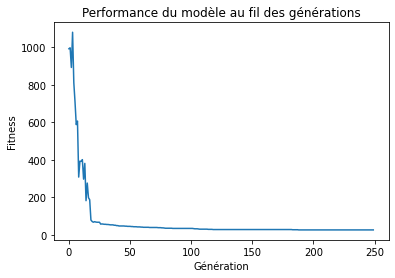

In [11]:
# Tracer les scores de fitness
plt.plot(best_fitness_scores)
plt.title('Performance du modèle au fil des générations')
plt.xlabel('Génération')
plt.ylabel('Fitness')
plt.show()

# # Vérifier que tous les cours soient bien donnés dans la semaine
# all_courses_present, missing_courses = verify_all_courses_in_schedule(final_schedule, courses)
# if all_courses_present:
#     print("Tous les cours sont inclus dans l'emploi du temps.")
# else:
#     print("Certains cours sont manquants dans l'emploi du temps :", missing_courses)

